# Example 1c: Electrical models
In the first two examples, we mostly focused on different optical models and how they can be applied to an Si cell.
Here we will look at different electrical models, roughly in increasing order of how 'realistic' they are expected to be:

1. Two-diode model (2D)
2. Detailed balance (DB)
3. Depletion approximation (DA)
4. Poisson drift-diffusion solver (PDD)

In [81]:
import numpy as np
import matplotlib.pyplot as plt

from solcore.solar_cell import SolarCell, Layer, Junction
from solcore.solar_cell_solver import solar_cell_solver
from solcore.absorption_calculator import OptiStack, calculate_rat

from solcore import material, si

from solcore.interpolate import interp1d

## Setting up

Define some materials:

In [82]:
GaAs = material("GaAs")()
Al2O3 = material("Al2O3")()
Ag = material("Ag")()

wavelengths = si(np.linspace(300, 950, 200), "nm")

We are going to do an optical calculation first to get absorption for a GaAs layer; we will use this as an estimate for the EQE as input for the two-diode model.

In [83]:
OS = OptiStack([Layer(si("3um"), GaAs)], substrate=Ag)

Calculate reflection/absorption/transmission (note that we have to give the wavelength to this function in nm rather than m!)

In [84]:
RAT = calculate_rat(OS, wavelength=wavelengths*1e9, no_back_reflection=False)

Create a function which interpolates the absorption - note that we pass a function which returns the absorption when given a wavelength to the Junction, rather than a table of values!

In [85]:
eqe_func = interp1d(wavelengths, RAT["A"])

## 2D and DB junctions

Define the 2D junction with reasonable parameters for GaAs. The units of j01 and j01 are A/m^2. The units for the resistances are (Ohm m)^2. We use the standard ideality factors (1 and 2 respectively) for the two diodes:

In [86]:
twod_junction = Junction(kind='2D', n1=1, n2=2, j01=3e-17, j02=1e-7,
                         R_series=6e-4, R_shunt=5e4, eqe=eqe_func)

Define two instances of a detailed-balance type junction. In both cases, there will be a sharp absorption onset at the bandgap (1.42 eV for GaAs). By specifying A, we set the fraction of light above the bandgap that is absorbed (A = 1 means 100% absorption above the gap).

In [87]:
db_junction_A1 = Junction(kind='DB', Eg=1.42, A=1, R_shunt=1e4, n=1)
db_junction = Junction(kind='DB', Eg=1.42, A=0.8, R_shunt=1e4, n=1)

V = np.linspace(0, 1.5, 200)

Set some options and define solar cells based on these junctions:

In [88]:
opts = {'voltages': V, 'light_iv': True, 'wavelength': wavelengths, 'mpp': True}

solar_cell_db_A1 = SolarCell([db_junction_A1])
solar_cell_db = SolarCell([db_junction])
solar_cell_2d = SolarCell([twod_junction])

Calculate and plot the IV curves:

In [89]:
solar_cell_solver(solar_cell_db_A1, 'iv', user_options=opts)
solar_cell_solver(solar_cell_db, 'iv', user_options=opts)
solar_cell_solver(solar_cell_2d, 'iv', user_options=opts)

Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


**PLOT 1**: IV curves for the DB and 2D models.

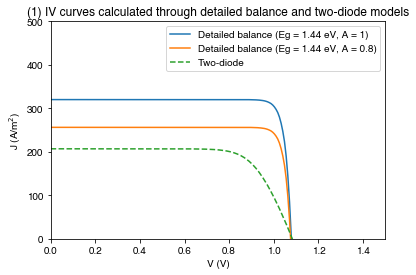

In [90]:
plt.figure()
plt.plot(*solar_cell_db_A1.iv["IV"], label='Detailed balance (Eg = 1.44 eV, A = 1)')
plt.plot(*solar_cell_db.iv["IV"], label='Detailed balance (Eg = 1.44 eV, A = 0.8)')
plt.plot(*solar_cell_2d.iv["IV"], '--', label='Two-diode')
plt.xlim(0, 1.5)
plt.ylim(0, 500)
plt.xlabel("V (V)")
plt.ylabel("J (A/m$^2$)")
plt.legend()
plt.title('(1) IV curves calculated through detailed balance and two-diode models')
plt.show()

As we expect, the two DB solar cells have a very similar shape, but the A = 1 case has a higher Jsc.
The two-diode model has a lower current, which makes sense as it's EQE is specified based on a more realistic
absorption calculation which includes front-surface reflection and an absorption edge which is not infinitely
sharp at the bandgap, as is assumed by the detailed balance model.

## DA and PDD junctions

Now let's consider the two slightly more complex models, which will actually take into account the absorption profile
of light in the cell and the distribution of charge carriers; the depletion approximation and the Poisson drift-diffusion
solver.

*Note:* for the PDD example to work, the PDD solver must be installed correctly; see the [Solcore documentation](http://docs.solcore.solar/en/master/Installation/installation.html) for more
information.

In [91]:
T = 293 # ambient temperature

window = material('AlGaAs')(T=T, Na=si("5e18cm-3"), Al=0.8)
p_GaAs = material('GaAs')(T=T, Na=si("1e18cm-3"), electron_diffusion_length=si("400nm"))
n_GaAs = material('GaAs')(T=T, Nd=si("8e16cm-3"), hole_diffusion_length=si("8um"))
bsf = material('GaAs')(T=T, Nd=si("2e18cm-3"))

SC_layers = [Layer(width=si('150nm'), material=p_GaAs, role="Emitter"),
                   Layer(width=si('2850nm'), material=n_GaAs, role="Base"),
                   Layer(width=si('200nm'), material=bsf, role="BSF")]

`sn` and `sp` are the surface recombination velocities (in m/sec). `sn` is the SRV for the n-doped junction, `sp` for the
p-doped junction.

In [92]:
# Depletion approximation:
solar_cell_da = SolarCell(
    [Layer(width=si("90nm"), material=Al2O3), Layer(width=si('20nm'),
                                                    material=window, role="Window"),
     Junction(SC_layers, sn=5e4, sp=5e4, kind='DA')],
    R_series=0, substrate=Ag
)

In [93]:
# Drift-diffusion solver:
solar_cell_pdd = SolarCell(
    [Layer(width=si("90nm"), material=Al2O3), Layer(width=si('20nm'),
                                                    material=window, role="Window"),
     Junction(SC_layers, sn=5e4, sp=5e4, kind='PDD')],
    R_series=0, substrate=Ag
)

In both cases, we set the series resistance to 0. Other loss factors, such as shading, are also assumed to be zero by default.

In [94]:
#| output: false

opts["optics_method"] = "TMM" # Use the transfer-matrix method to calculate the cell's optics
opts["position"] = 1e-10 # This is the spacing used when calculating the depth-dependent absorption (0.1 nm)
opts["no_back_reflection"] = False

solar_cell_solver(solar_cell_da, "iv", user_options=opts);
solar_cell_solver(solar_cell_da, "qe", user_options=opts);

solar_cell_solver(solar_cell_pdd, "iv", user_options=opts);
solar_cell_solver(solar_cell_pdd, "qe", user_options=opts);

      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2703E-18    0.3289E-19    0.9817E-22    0.6197E-28    0.3289E-19         2
         2   -0.2703E-17    0.9766E-19    0.1149E-21    0.3541E-26    0.9766E-19         2
         3   -0.2703E-16    0.2674E-19    0.1225E-20    0.3542E-24    0.2671E-19         2
         4   -0.2703E-15    0.9640E-19    0.8997E-19    0.3547E-22    0.3463E-19         2
         5   -0.2702E-14    0.9365E-17    0.9103E-17    0.3595E-20    0.2200E-17         2
         6   -0.2703E-13    0.6059E-18    0.6032E-18    0.1519E-21    0.5643E-19         2
         7   -0.2703E-12    0.1498E-16    0.1498E-16    0.2272E-20    0.2843E-18         2
         8   -0.2703E-11    0.1607E-17    0.1582E-17    0.2959E-21    0.2819E-18         2
         9   -0.2703E-10    0.1795E-17    0.1570E-17    0.3950E-21    0.8712E-18         2
        10   -0.2703E-09    0.3941E-19    0.1360E-19    0.1123E-25    0.3699E-19         2


/Users/phoebe/Documents/develop/solcore5/solcore/analytic_solar_cells/depletion_approximation.py:617: RuntimeWarning: invalid value encountered in true_divide
  iqe =  j_sc / current_absorbed


Solving optics of the solar cell...
Calculating RAT...
Calculating absorption profile...
Solving IV of the junctions...
Solving IV...
Solving equilibrium...
Processing structure...
 CREATE MESH...
 Masternodes at (nm):
       0.0
     149.9
     150.0
    2999.9
    3000.0
    3200.0
...done!
  
 Initial number of nodes (M+1):          299
 Refining mesh... 
 ... Finished!
 Mesh with          105  nodes.
 ----------------------------------

  
 Starting EQUILIBRIUM... 
...done!

 Remeshing...  M+1 =          135  nodes.
 EQUILIBRIUM Output Code: Reached Absolute Tolerance.                       
     Res:    5.55010459E-29
 Elapsed time =    4.91449982E-02 s
  
...done!
  
 Starting LIGHTSC... 

      step  Jtot (A/m^2)          Res          Res-h    Res Poisson     Res-e        Info
         1   -0.2703E-18    0.3289E-19    0.9817E-22    0.6197E-28    0.3289E-19         2
         2   -0.2703E-17    0.9766E-19    0.1149E-21    0.3541E-26    0.9766E-19         2
         3   -0.2703E-1

**PLOT 2**: IV curves for the DA and PDD models

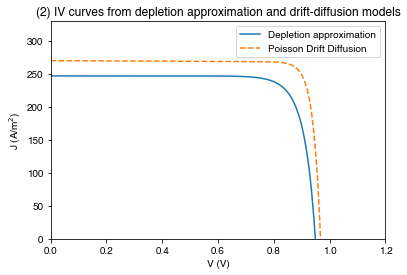

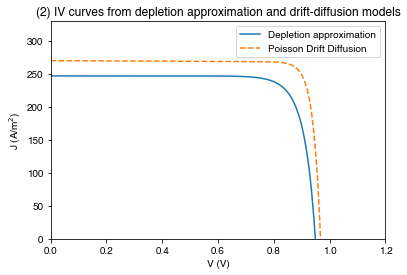

In [95]:
plt.figure()
plt.plot(*solar_cell_da.iv["IV"], label="Depletion approximation")
plt.plot(*solar_cell_pdd.iv["IV"], '--', label="Poisson Drift Diffusion")
plt.xlim(0, 1.2)
plt.ylim(0, 330)
plt.legend()
plt.xlabel("V (V)")
plt.ylabel("J (A/m$^2$)")
plt.title('(2) IV curves from depletion approximation and drift-diffusion models')
plt.show()

**PLOT 3**: EQE and absorption calculated for the PDD and DA models.

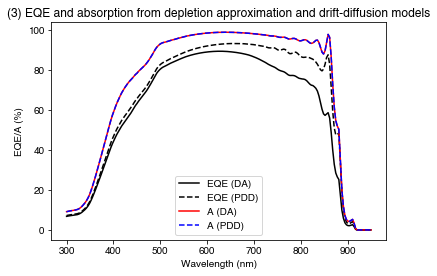

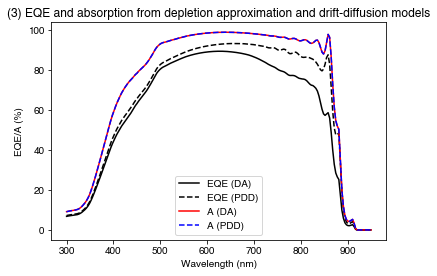

In [96]:
plt.figure()
plt.plot(wavelengths*1e9, 100*solar_cell_da[2].eqe(wavelengths), 'k-', label="EQE (DA)")
plt.plot(wavelengths*1e9, 100*solar_cell_pdd[2].eqe(wavelengths), 'k--', label="EQE (PDD)")
plt.plot(wavelengths*1e9, 100*solar_cell_da[2].layer_absorption, 'r-', label="A (DA)")
plt.plot(wavelengths*1e9, 100*solar_cell_pdd[2].layer_absorption, 'b--', label="A (PDD)")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("EQE/A (%)")
plt.title('(3) EQE and absorption from depletion approximation and drift-diffusion models')
plt.show()